Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

In [1]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'

# Decision Trees

## Kaggle

**Task 1:** [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website (the URL is in Slack). Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.

## Wrangle Data

**Task 2:** Add to the code below so that `id` is set as the index for `df`.

In [11]:
import pandas as pd

# Filepath for code to run locally
local_filepath = '/Users/keila/Documents/Lambda/Units_Git/DS-Unit-2-Kaggle-Challenge/data/' 

# Creating DataFrame that contains both feature matrix and target vector
df = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
              pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv')).set_index('id')

df.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


**Test 2**

In [10]:
'''Task 2 Testing'''

assert isinstance(df, pd.DataFrame), 'Have you created the DataFrame `df`?'
assert df.shape == (59400, 40), '`df` is the wrong shape. Did you set the index to `id`?'
assert 69572 in df.index, 'The index for `df` is has the wrong values. Did you set the index to `id`?'

## Split Data

**Task 3:** Create your target vector `y` and feature matrix `X`.

In [12]:
target = 'status_group'

# Splitting data into feature matrix and target vector
y = df[target]
X = df.drop(columns = target)

**Test 3**

In [13]:
'''Task 3 Testing'''

assert isinstance(X, pd.DataFrame), '`X` is the wrong data type.'
assert isinstance(y, pd.Series), '`y` is the wrong data type.'
assert y.shape == (59400,), '`y` is the wrong shape.'
assert X.shape == (59400,39), '`X` is the wrong shape.'

We already have a test set for this model, the `test.csv` that you'll use to make the predictions you'll upload to Kaggle. However, since our competition only allows for 2 submissions per day, we need a way to estimate our training error so that we can quickly iterate and improve our model. We can achieve this by creating a validation set from the data we have.

**Task 4:** Split `X` and `y` into training and validation sets. Your validation set should be 20% of the data you have. You should have four variables: `X_train`, `X_val`, `y_train`, and `y_val`. 

In [14]:
from sklearn.model_selection import train_test_split

# Splitting data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)

**Test 4**

In [15]:
'''Task 4 Testing'''

assert X_train.shape == (47520, 39), '`X_train` is the wrong shape.'
assert X_val.shape == (11880, 39), '`X_val` is the wrong shape.'
assert y_train.shape == (47520,), '`y_train` is the wrong shape.'
assert y_val.shape == (11880,), '`y_val` is the wrong shape.'

## Establish Baseline

**Task 5:** This is a **classification** problem, so you need to establish the baseline accuracy for your training set. Find the majority class for `y_train` and calculate the percentage of labels in `y_train` belonging to that class. Assign your answer to the variable name `baseline_acc`.

In [17]:
# Establishing baseline accuracy
baseline_acc = y_train.value_counts(normalize = True).max()

print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.5429713804713805


In [242]:
y_train.value_counts(normalize = True)

functional                 0.542971
non functional             0.384091
functional needs repair    0.072938
Name: status_group, dtype: float64

**Task 5**

In [18]:
'''Task 5 Testing'''

assert isinstance(baseline_acc, float), '`baseline_acc` should be a `float`.'
assert 0.0 <= baseline_acc <= 1.0, '`baseline_acc` is a score that should be between 0 and 1.'

## Build Model

**Task 6:** Create a model named `model` and train it with your training data. Your model should be a pipeline with (a) transformers that you think are appropriate to this dataset and (b) a `DecisionTreeClassifier` as your predictor. **Tip:** How can you transform categorical features and missing values in order to train your model?

In [117]:
# Depths to test
depths = range(2, 32, 2)

# Empty lists to append accuracy scores into
train_acc = []
val_acc = []

# Create models with various depths from depths and put accuracies in empty lists
for depth in depths:
    tree_model = make_pipeline(
      OrdinalEncoder(), 
      SimpleImputer(), 
      DecisionTreeClassifier(max_depth = depth, random_state = 42)
)

    tree_model.fit(X_train, y_train)

    train_acc.append(tree_model.score(X_train, y_train))
    val_acc.append(tree_model.score(X_val, y_val))

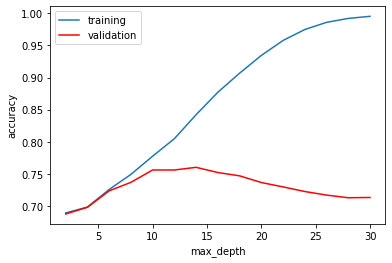

In [25]:
import matplotlib.pyplot as plt

# Visualize validation and training curve
plt.plot(depths, train_acc, label = 'training')
plt.plot(depths, val_acc, color = 'r', label = 'validation')

plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend();

In [314]:
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

weights = {'functional': 0.54,
           'non functional': 0.36,
           'functional needs repair': 0.1}

# Build model with pipeline
model = make_pipeline(OrdinalEncoder(),
                      SimpleImputer(),
                      DecisionTreeClassifier(max_depth = 14, random_state=42, min_samples_leaf = 4,
                                             max_features = 0.99, class_weight = weights))

# Fit mode
model.fit(X_train, y_train);

**Test 6**

In [20]:
'''Task 6 Testing'''

assert len(model) > 1, 'Your model pipeline should have multiple steps.'
assert isinstance(model[-1], DecisionTreeClassifier), 'Your pipline should end in a `DecisionTreeClassifier`.'
assert hasattr(model, 'classes_'), 'Have you fit your model?'

## Check Metrics

**Task 7:** Calculate the training and validation accuracy of your model, and assign them to the valiables `training_acc` and `validation_acc`, respectively. Your validation accuracy should be greater than your baseline accuracy.

In [315]:
# Accuracy of model on training set
training_acc = model.score(X_train, y_train)

#Accuracy of model on validation set
validation_acc = model.score(X_val, y_val)

print('Training Accuracy:', training_acc)
print('Validation Accuracy:', validation_acc)

Training Accuracy: 0.8167929292929293
Validation Accuracy: 0.7678451178451179


**Test 7**

In [316]:
'''Task 7 Testing'''

assert isinstance(training_acc, float)
assert isinstance(validation_acc, float)
assert 0.0 <= training_acc <= 1.0
assert 0.0 <= validation_acc <= 1.0

## Create Kaggle Submission

**Task 8:** Load `'waterpumps/test.csv'` into a DataFrame named `X_test`. Generate a list of predictions, and then put them into a DataFrame `submission`. Be sure that `submission` has the same index as `X_test` and that the column name for your predictions is `'status_group'`.  

In [318]:
# Read in test data
X_test = pd.read_csv(DATA_PATH + 'waterpumps/test_features.csv', index_col='id')

# Make predictions on test data with model
predictions = model.predict(X_test)

# Put predictions in correct format for submission
submission = X_test.assign(status_group = predictions)

submission = submission[['status_group']]

submission.head()

,status_group
id,
50785,functional
51630,functional
17168,non functional
45559,non functional
49871,functional


**Test 8**

In [39]:
'''Task 8 Testing'''

assert isinstance(submission, pd.DataFrame), '`submission` should be a DataFrame.'
assert len(submission) == 14358, '`submission` should have 14358 rows.'

**Task 9 (`stretch goal`):** Save `submission` as a csv file using [`.to_csv()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html) and submit it to our Kaggle competition.

In [319]:
# Create csv file to submit to Kaggle
submission.to_csv('mod1_submission.csv')

## Explain

**Task 10 (`stretch goal`):** Make a horizontal barchart of the 10 most important features for your model.

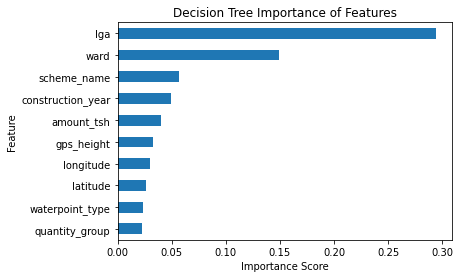

In [324]:
# Get top 10 most important features in model
importances = model.named_steps['decisiontreeclassifier'].feature_importances_
top_10 = pd.Series(importances).sort_values()

# Get feature names
feature_names = X.columns

# Get top 10 features' names
top_names = [feature_names[33], feature_names[37], feature_names[6], feature_names[5], feature_names[3],
             feature_names[0], feature_names[22], feature_names[20], feature_names[15], feature_names[14]]

# Plot the top 10 importances
ax = top_10.tail(10).plot(kind = 'barh', title = 'Decision Tree Importance of Features')
ax.set_yticklabels(top_names)
ax.set_ylabel('Feature')
ax.set_xlabel('Importance Score');